# RDataFrame advanced features
There are still many features available with RDataFrame that might serve your analysis needs!

## Working with `numpy` arrays
RDataFrame offers interoperability with `numpy` arrays. It can be created from a dictionary of such arrays and it can also export its contents to the same format. All operations are available also when using the `numpy`-based dataset.

**Note:** this support is limited to one-dimensional numpy arrays, which are directly mapped to columns in the RDataFrame.

In [9]:
import numpy
import ROOT

np_dict = {colname: numpy.random.rand(100) for colname in ["a","b","c"]}

df = ROOT.RDF.MakeNumpyDataFrame(np_dict)

print(f"Columns in the RDataFrame: {df.GetColumnNames()}")

Columns in the RDataFrame: { "a", "b", "c" }


Number of rows in the dataset: 100
Average value of column a: 0.5297942868114833


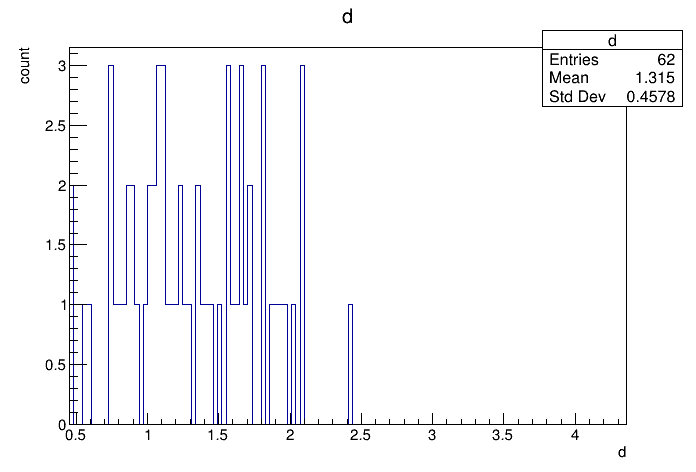

In [11]:
co = df.Count()
m_a = df.Mean("a")

fil1 = df.Filter("c < 0.7")
def1 = fil1.Define("d", "a+b+c")
h = def1.Histo1D("d")

c = ROOT.TCanvas()
h.Draw()

print(f"Number of rows in the dataset: {co.GetValue()}")
print(f"Average value of column a: {m_a.GetValue()}")
c.Draw()

## Multiple concurrent RDataFrame runs
If your analysis needs multiple RDataFrames to run (for example multiple dataset samples, data vs simulation etc.), the `ROOT.RDF.RunGraphs` 

In [2]:
ROOT.EnableImplicitMT()
treename1 = "myDataset"
filename1 = "https://github.com/root-project/root/raw/master/tutorials/dataframe/df017_vecOpsHEP.root"
treename2 = "dataset"
filename2 = "data/example_file.root"

df1 = ROOT.RDataFrame(treename1, filename1)
df2 = ROOT.RDataFrame(treename2, filename2)
h1 = df1.Histo1D("px")
h2 = df2.Histo1D("a")
 

ROOT.RDF.RunGraphs((h1, h2))

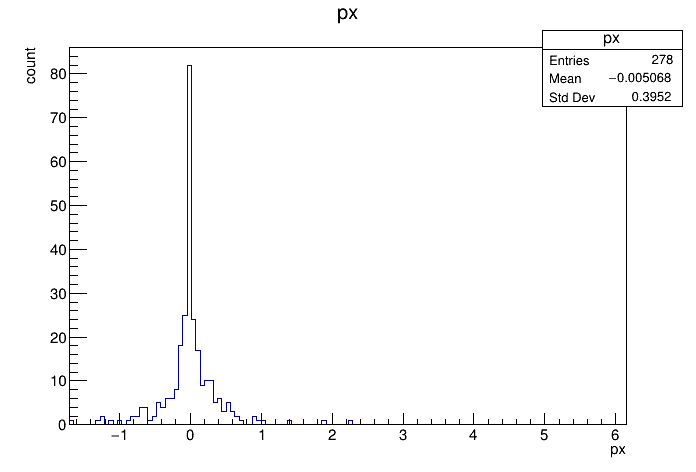

In [3]:
c = ROOT.TCanvas()
h1.Draw()
c.Draw()

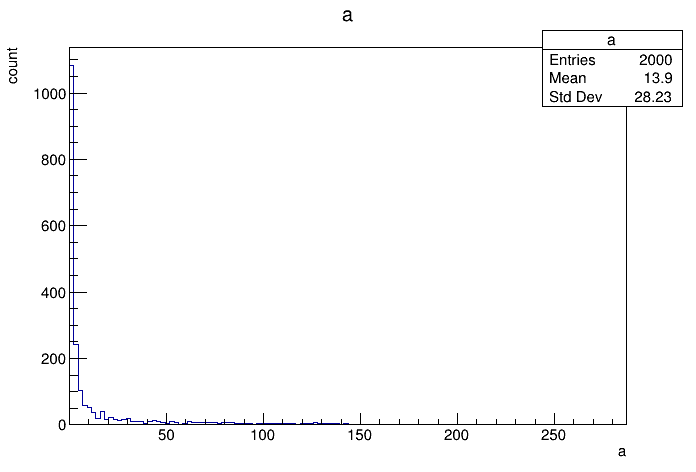

In [4]:
c = ROOT.TCanvas()
h2.Draw()
c.Draw()

# Distributed RDataFrame

An `RDataFrame` analysis written in Python can be executed both *locally* - possibly in parallel on the cores of the machine - and *distributedly* by offloading computations to external resources, including [Spark](https://spark.apache.org/) and [Dask](https://dask.org/) clusters. This feature is enabled by the architecture depicted below, which shows that RDataFrame computation graphs can be mapped to different kinds of resources via backends. In this notebook we will exercise the Spark backend, which divides an `RDataFrame` input dataset in logical ranges and submits computations for each of those ranges to Spark resources.

<img src="images/DistRDF_architecture.png" alt="Distributed RDataFrame">

## Create a Spark context

In order to work with a Spark cluster we need a `SparkContext` object, which represents the connection to that cluster and allows to configure execution-related parameters (e.g. number of cores, memory). When running this notebook from [SWAN](https://swan.cern.ch), a `SparkContext` object is already created for us when connecting to the selected cluster via the graphical interface. Alternatively, we could create a `SparkContext` as described in the [Spark documentation](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.SparkContext.html).

In [5]:
import pyspark
sc = pyspark.SparkContext.getOrCreate()

21/08/25 15:52:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Create a ROOT dataframe

We now create an RDataFrame based on the same dataset seen in the exercise [rdataframe-dimuon](exercises/rdataframe-dimuon.ipynb).

A Spark `RDataFrame` receives two extra parameters: the number of partitions to apply to the dataset (`npartitions`) and the `SparkContext` object (`sparkcontext`). Besides that detail, a Spark `RDataFrame` is not different from a local `RDataFrame`: the analysis presented in this notebook would not change if we wanted to execute it locally.

In [6]:
# Use a Spark RDataFrame
RDataFrame = ROOT.RDF.Experimental.Distributed.Spark.RDataFrame

df = RDataFrame("Events",
                "root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root",
                npartitions=4,
                sparkcontext=sc)

## Run your analysis unchanged

From now on, the rest of your application can be written **exactly** as we have seen with local RDataFrame. The goal of the distributed RDataFrame module is to support all the traditional RDataFrame operations (those that make sense in a distributed context at least). Currently only a subset of those is available and can be found in the corresponding [section of the documentation](https://root.cern/doc/master/classROOT_1_1RDataFrame.html#distrdf)

In [7]:
%%time
df_2mu = df.Filter("nMuon == 2", "Events with exactly two muons")
df_c = df_2mu.Count()
print(f"Number of events after filter: {df_c.GetValue()}")

Number of events after filter: 31104343
CPU times: user 280 ms, sys: 58.3 ms, total: 338 ms
Wall time: 26.6 s
